# 一、梯度下降原理

## 1、为什么负梯度方向是最快下降方向

**参考1：[为什么局部下降最快的方向就是梯度的负方向？](https://blog.csdn.net/red_stone1/article/details/80212814)**

从泰勒一阶展开式的角度，推导了，当下降方向与梯度方向相反时，函数值会下降，且是下降的最大方向

[多元变量函数，泰勒如何展开？](https://zhuanlan.zhihu.com/p/32274749)

$f(\theta)-f\left(\theta_{0}\right) \approx \eta v \cdot \nabla f\left(\theta_{0}\right)<0$

$\eta$为标量，表示步进长度。在$\eta$一定时，只有当v与 $\nabla f\left(\theta_{0}\right)$ 完全相反方向时，不仅保证值是负值，且值最大。

**参考2：[机器学习－梯度下降算法](http://www.hanlongfei.com/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0/2015/07/29/gradient/)**
这是一个在CMU读书的学生的博客，感觉国外的教学很好

从方向导数求极值的角度，证明了方向导数的极值等于函数在该点梯度的范数，感觉这里的推导更严谨一些

# 二、自己实现

In [87]:
import numpy as np
import torch
from copy import deepcopy,copy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
data = np.loadtxt("Admission_Predict.csv",delimiter=",",skiprows=1)

In [88]:
data.shape

(500, 9)

In [89]:
data[:5]

array([[  1.  , 337.  , 118.  ,   4.  ,   4.5 ,   4.5 ,   9.65,   1.  ,
          0.92],
       [  2.  , 324.  , 107.  ,   4.  ,   4.  ,   4.5 ,   8.87,   1.  ,
          0.76],
       [  3.  , 316.  , 104.  ,   3.  ,   3.  ,   3.5 ,   8.  ,   1.  ,
          0.72],
       [  4.  , 322.  , 110.  ,   3.  ,   3.5 ,   2.5 ,   8.67,   1.  ,
          0.8 ],
       [  5.  , 314.  , 103.  ,   2.  ,   2.  ,   3.  ,   8.21,   0.  ,
          0.65]])

In [90]:
def getdata(origin_data, col_num, norm = False):
    """
    return:
        x_data_array: array
        y_data_array: array
        x_data: Tensor
        y_data: Tensor
    """
    x_data_array = origin_data[:,col_num]
    y_data_array = origin_data[:,-1]
    print("x_data_array.shape:",x_data_array.shape)
    print("y_data_array.shape:",y_data_array.shape)
    if norm:
        min_max_scaler = MinMaxScaler()
        x_data_array = min_max_scaler.fit_transform(x_data_array)
    x_data = torch.Tensor(x_data_array)
    y_data = torch.Tensor(y_data_array)
    return x_data_array,y_data_array,x_data,y_data

In [91]:
class Model(torch.nn.Module):
    
    def __init__(self, dim_in, dim_out):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(dim_in, dim_out, bias=False) #为了简单，不加偏置
        self.weights_init(self.linear)
        for submodel in self.children():
            print(submodel)
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            m.weight.data = torch.randn(m.weight.data.size()[0],m.weight.data.size()[1])
            #m.bias.data = torch.randn(m.bias.data.size()[0])

In [92]:
def plotLoss3D(x_data_array, y_data_array, low_bound, upper_bound, step_size=0.1):
    """
    only for 2 features data
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    #create w1、w2
    r = np.arange(low_bound, upper_bound, step_size)
    w = []
    for i in r:
        tmp = []
        tmp.append(i)
        for j in r:
            tmp.append(j)
            w.append(deepcopy(tmp))
            tmp.pop()
    w = np.array(w)
    
    #calculate L on each point
    def cal_loss(wi):
        L = np.average(np.power(x_data_array @ wi - y_data_array,2))/2
        return L
    loss = []
    for i in range(w.shape[0]):
        loss.append(cal_loss(w[i]))
    
    #plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    x = w[:,0]
    y = w[:,1]
    z = loss

    ax.plot_trisurf(x,y,z)

### 对比归一化和不归一化的Loss图像

#### 1、不归一化

In [93]:
x_data_array,y_data_array,x_data,y_data = getdata(data, [1,3])
x_data_array[:5]

x_data_array.shape: (500, 2)
y_data_array.shape: (500,)


array([[337.,   4.],
       [324.,   4.],
       [316.,   3.],
       [322.,   3.],
       [314.,   2.]])

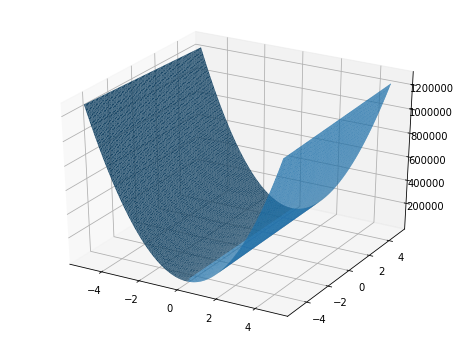

In [94]:
plotLoss3D(x_data_array, y_data_array, -5, 5, 0.1)

#### 2、归一化

In [95]:
x_data_array_norm,y_data_array_norm,x_data_norm,y_data_norm = getdata(data, [1,3], norm=True)
x_data_array_norm[:5]

x_data_array.shape: (500, 2)
y_data_array.shape: (500,)


array([[0.94, 0.75],
       [0.68, 0.75],
       [0.52, 0.5 ],
       [0.64, 0.5 ],
       [0.48, 0.25]])

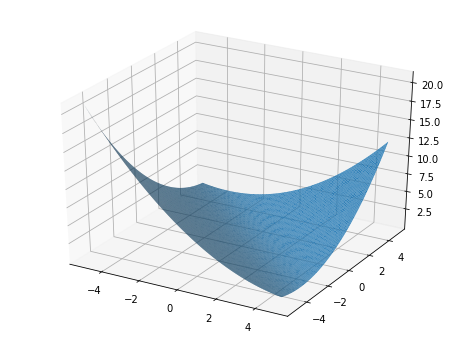

In [96]:
plotLoss3D(x_data_array_norm, y_data_array_norm, -5, 5, 0.1)

可以看到，因为MSE损失函数是凸函数，所以没有鞍点，好像也没有局部最优点。

归一化后，很明显的loss的值变小了很多，这样在选择学习率的时候应该会好选点，以MSE为例，若weight的迭代值与loss正相关，若loss太大，学习率也选的太大，就会导致下面出现的梯度爆炸的情况，除非将学习率选的很小。如果归一化的话，不同的数据集，都可以共用一个默认的相同学习率。

## 1、BGD

In [97]:
epochs = 100

In [98]:
def opt_BGD(x_data, y_data, epochs, rate):
    lossdata = []
    print("rate is:",rate)
    for each in range(epochs):
        y_pred = model_BGD(x_data)
        loss = torch.mean(torch.pow(y_pred-y_data, 2))/2
        lossdata.append(loss.data)
        loss.backward()
        for i in model_BGD.parameters():
            #print("para: ",i.data)
            i.data -= rate*i.grad.data
            i.grad.data.zero_()
        if each%10 == 0:
            print("in epoch ",each," loss is ",loss.data)
    return lossdata

#### 未归一化的数据

In [99]:
rates= [0.1,0.01,0.001,0.0001,0.00001,0.000001]
lossdata = []
for rate in rates:
    model_BGD = Model(x_data.shape[1],1)
    tmp = opt_BGD(x_data, y_data, epochs, rate)
    lossdata.append(tmp)

Linear(in_features=2, out_features=1, bias=False)
rate is: 0.1
in epoch  0  loss is  tensor(48754.2422)
in epoch  10  loss is  tensor(inf)
in epoch  20  loss is  tensor(nan)
in epoch  30  loss is  tensor(nan)
in epoch  40  loss is  tensor(nan)
in epoch  50  loss is  tensor(nan)
in epoch  60  loss is  tensor(nan)
in epoch  70  loss is  tensor(nan)
in epoch  80  loss is  tensor(nan)
in epoch  90  loss is  tensor(nan)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.01
in epoch  0  loss is  tensor(6557.7236)
in epoch  10  loss is  tensor(inf)
in epoch  20  loss is  tensor(nan)
in epoch  30  loss is  tensor(nan)
in epoch  40  loss is  tensor(nan)
in epoch  50  loss is  tensor(nan)
in epoch  60  loss is  tensor(nan)
in epoch  70  loss is  tensor(nan)
in epoch  80  loss is  tensor(nan)
in epoch  90  loss is  tensor(nan)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.001
in epoch  0  loss is  tensor(53066.8828)
in epoch  10  loss is  tensor(inf)
in epoch  20  loss is

可以看到在学习率小的时候，loss会变的超级大(inf),直到nan。经过分析这是因为loss大-->diff(weight)大-->越过了最低点，到了另外一边，且比目前的loss还高的位置-->loss大，如此反复，就产生了这个现象

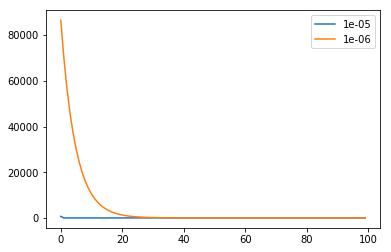

In [100]:
for index,rate in enumerate(rates):
    if index < 4:
        continue
    plt.plot(lossdata[index],label=str(rate))
    
plt.legend(loc='upper right')
plt.show()

#### 用归一化后的数据看一下

In [101]:
rates= [0.1,0.01,0.001,0.0001,0.00001,0.000001]
lossdata = []
for rate in rates:
    model_BGD = Model(x_data_norm.shape[1],1)
    tmp = opt_BGD(x_data_norm, y_data_norm, epochs, rate)
    lossdata.append(tmp)

Linear(in_features=2, out_features=1, bias=False)
rate is: 0.1
in epoch  0  loss is  tensor(2.5451)
in epoch  10  loss is  tensor(0.6917)
in epoch  20  loss is  tensor(0.2251)
in epoch  30  loss is  tensor(0.1071)
in epoch  40  loss is  tensor(0.0767)
in epoch  50  loss is  tensor(0.0684)
in epoch  60  loss is  tensor(0.0657)
in epoch  70  loss is  tensor(0.0645)
in epoch  80  loss is  tensor(0.0636)
in epoch  90  loss is  tensor(0.0628)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.01
in epoch  0  loss is  tensor(0.0688)
in epoch  10  loss is  tensor(0.0664)
in epoch  20  loss is  tensor(0.0643)
in epoch  30  loss is  tensor(0.0624)
in epoch  40  loss is  tensor(0.0608)
in epoch  50  loss is  tensor(0.0594)
in epoch  60  loss is  tensor(0.0581)
in epoch  70  loss is  tensor(0.0570)
in epoch  80  loss is  tensor(0.0561)
in epoch  90  loss is  tensor(0.0553)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.001
in epoch  0  loss is  tensor(0.0844)
in epoch  10 

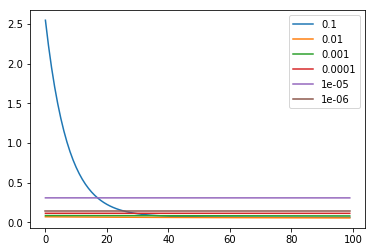

In [102]:
for index,rate in enumerate(rates):
    plt.plot(lossdata[index],label=str(rate))
    
plt.legend(loc='upper right')
plt.show()

### 综上，解释为什么线性模型需要归一化

在损失函数是MSE时(即loss的值与权重更新的大小相关时)

* 若不归一化数据，为了避免梯度爆炸，必须选很小的学习率，虽然可以在初期下降很快，但是到后期，因为学习率很小，loss也很小了，导致权重几乎不更新

* 若归一化数据，几乎避免了梯度爆炸(因为我们一般学习率都小于1，如果你设置学习率为100，也有可能梯度爆炸)，可以取一个不那么小的学习率，在loss比较小的时候，依旧可以优化

* 至于说，归一化能让loss更快的下降，这点我无法证明

## 2、SGD

In [103]:
epochs = 100

In [150]:
def opt_SGD(x_data, y_data, epochs, rate):
    lossdata = []
    print("rate is:",rate)
    y_data = y_data.reshape(-1,1) # should reshape to hstack
    alldata = np.hstack((x_data,y_data))
    sample_size = x_data.shape[0]
    for each in range(epochs):
        for i in range(sample_size):
            np.random.shuffle(alldata)
            x_data = alldata[i,:-1] # random pick a sample
            y_data = alldata[i,-1]
            
            x_data = torch.Tensor(x_data.reshape(1,-1)) # must reshape and change to tensor, otherwise have error
            y_data = torch.Tensor(y_data.reshape(1,-1))
            
            y_pred = model_SGD(x_data)
            loss = torch.mean(torch.pow(y_pred-y_data, 2))/2
            lossdata.append(loss.data)
            loss.backward()
            for i in model_SGD.parameters():
                #print("para: ",i.data)
                i.data -= rate*i.grad.data
                i.grad.data.zero_()
        if each%10 == 0:
            print("in epoch ",each," loss is ",loss.data)
    return lossdata

In [151]:
rates= [0.1,0.01,0.001,0.0001,0.00001,0.000001]
lossdata = []
for rate in rates:
    model_SGD = Model(x_data_norm.shape[1],1)
    tmp = opt_SGD(x_data_norm, y_data_norm, epochs, rate)
    lossdata.append(tmp)

Linear(in_features=2, out_features=1, bias=False)
rate is: 0.1
in epoch  0  loss is  tensor(0.0733)
in epoch  10  loss is  tensor(0.0013)
in epoch  20  loss is  tensor(0.0311)
in epoch  30  loss is  tensor(0.0018)
in epoch  40  loss is  tensor(0.0010)
in epoch  50  loss is  tensor(0.0009)
in epoch  60  loss is  tensor(0.0022)
in epoch  70  loss is  tensor(0.0076)
in epoch  80  loss is  tensor(0.0431)
in epoch  90  loss is  tensor(0.0728)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.01
in epoch  0  loss is  tensor(0.0153)
in epoch  10  loss is  tensor(3.7829e-05)
in epoch  20  loss is  tensor(0.0630)
in epoch  30  loss is  tensor(0.0460)
in epoch  40  loss is  tensor(0.0134)
in epoch  50  loss is  tensor(0.0364)
in epoch  60  loss is  tensor(0.0075)
in epoch  70  loss is  tensor(0.0009)
in epoch  80  loss is  tensor(0.0790)
in epoch  90  loss is  tensor(0.0118)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.001
in epoch  0  loss is  tensor(0.0572)
in epoch 

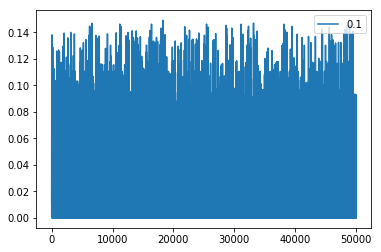

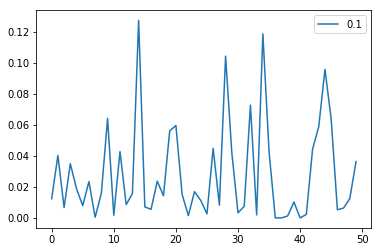

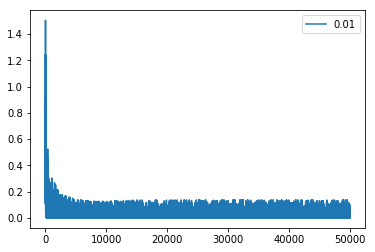

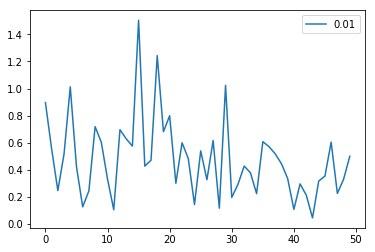

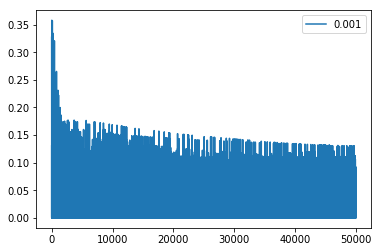

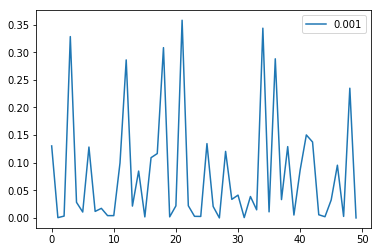

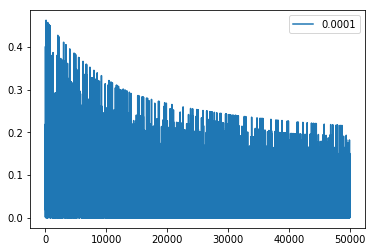

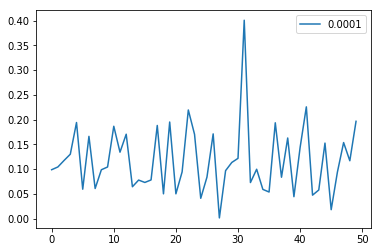

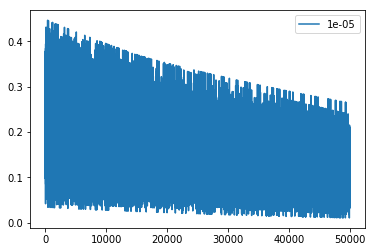

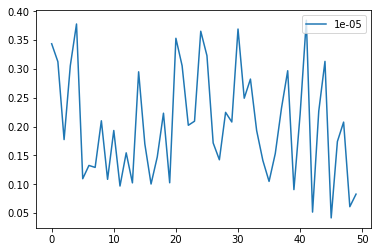

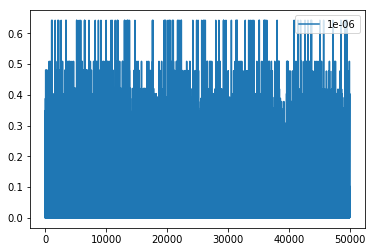

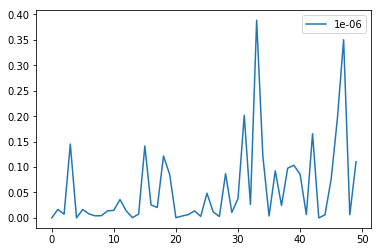

In [152]:
for index,rate in enumerate(rates):
    plt.plot(lossdata[index],label=str(rate))
    plt.legend(loc='upper right')
    plt.show()
    plt.plot(lossdata[index][:50],label=str(rate))
    plt.legend(loc='upper right')
    plt.show()

### BGD 和 SGD 对比分析

* 很显然，SGD只需要迭代几个样本后，loss就能下降到最小值附近，但是BGD一次迭代，需要计算全部样本，不仅计算不如SGD快，在开始的下降幅度也不如SGD

* 但是呢，SGD在最小值附近会震荡，只有合适的学习率的时候，才会收敛

## 3、MGD

In [153]:
epochs = 100

In [157]:
def opt_MGD(x_data, y_data, epochs, rate):
    lossdata = []
    print("rate is:",rate)
    y_data = y_data.reshape(-1,1) # should reshape to hstack
    alldata = np.hstack((x_data,y_data))
    sample_size = x_data.shape[0]
    for each in range(epochs):
        np.random.shuffle(alldata)
        x_data = alldata[0:64,:-1] # random pick a sample
        y_data = alldata[0:64,-1]

        x_data = torch.Tensor(x_data.reshape(64,-1)) # must reshape and change to tensor, otherwise have error
        y_data = torch.Tensor(y_data.reshape(64,-1))

        y_pred = model_MGD(x_data)
        loss = torch.mean(torch.pow(y_pred-y_data, 2))/2
        lossdata.append(loss.data)
        loss.backward()
        for i in model_MGD.parameters():
            #print("para: ",i.data)
            i.data -= rate*i.grad.data
            i.grad.data.zero_()
        if each%10 == 0:
            print("in epoch ",each," loss is ",loss.data)
    return lossdata

In [158]:
rates= [0.1,0.01,0.001,0.0001,0.00001,0.000001]
lossdata = []
for rate in rates:
    model_MGD = Model(x_data_norm.shape[1],1)
    tmp = opt_MGD(x_data_norm, y_data_norm, epochs, rate)
    lossdata.append(tmp)

Linear(in_features=2, out_features=1, bias=False)
rate is: 0.1
in epoch  0  loss is  tensor(0.0641)
in epoch  10  loss is  tensor(0.0282)
in epoch  20  loss is  tensor(0.0185)
in epoch  30  loss is  tensor(0.0195)
in epoch  40  loss is  tensor(0.0176)
in epoch  50  loss is  tensor(0.0140)
in epoch  60  loss is  tensor(0.0153)
in epoch  70  loss is  tensor(0.0182)
in epoch  80  loss is  tensor(0.0169)
in epoch  90  loss is  tensor(0.0133)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.01
in epoch  0  loss is  tensor(0.2120)
in epoch  10  loss is  tensor(0.1661)
in epoch  20  loss is  tensor(0.1804)
in epoch  30  loss is  tensor(0.1494)
in epoch  40  loss is  tensor(0.1248)
in epoch  50  loss is  tensor(0.1196)
in epoch  60  loss is  tensor(0.0758)
in epoch  70  loss is  tensor(0.0777)
in epoch  80  loss is  tensor(0.0639)
in epoch  90  loss is  tensor(0.0736)
Linear(in_features=2, out_features=1, bias=False)
rate is: 0.001
in epoch  0  loss is  tensor(0.0670)
in epoch  10 

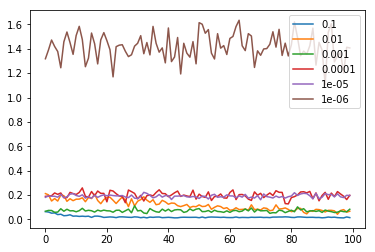

In [159]:
for index,rate in enumerate(rates):
    plt.plot(lossdata[index],label=str(rate))
    
plt.legend(loc='upper right')
plt.show()